In [157]:
import json
from boto3.dynamodb.types import TypeDeserializer

def ddb_deserialize(r, type_deserializer = TypeDeserializer()):
  return type_deserializer.deserialize({"M": r})

In [1094]:
import boto3
import pandas
import numpy as np

cols = ['quaternionTimestamp','linearAccerationTimestamp', 'quaternionW',	'quaternionX',	'quaternionY','quaternionZ', 'linearAccerationX', 'linearAccerationZ', 'linearAccerationY'	]

def name_switch(name):
  if 'rotate' in name:
    return 'rotate'
  elif 'squat' in name:
    return 'squat'
  elif 'square' in name:
    return 'square'
  elif 'flip' in name:
    return 'flip'
  

def ddb_query(query):
  client = boto3.client('dynamodb')
  items = []
  resp = client.execute_statement(Statement=query, Limit=1000)
  items.extend(resp['Items'])
  while 'LastEvaluatedKey' in resp:
    resp = client.execute_statement(Statement=query,Limit=1000,NextToken=resp["NextToken"])
    items.extend(resp['Items'])

  items = [ ddb_deserialize(r) for r in items ]

  return items

def query_sessions_and_sections(query, sectionTable="SessionSection-e3tq3jp6jjh4xjjpvydbqj64e4-dev"):
  
  sessions = ddb_query(query)
  sessions_df = pandas.DataFrame(sessions)

  sections_query= f"""SELECT * FROM "{sectionTable}" WHERE sessionID in {list(sessions_df['id'])} """
  sections = ddb_query(sections_query)
  sections_df = pandas.DataFrame(sections)
  
  return sessions_df, sections_df

def join_sessions_and_sections(sessions_df, sections_df):
  sections_df  = (sections_df.groupby(['sessionID'])
      .agg({'start': lambda x: x.tolist(),'end': lambda x: x.tolist()})
      .reset_index())
  sessions_df = sessions_df.set_index('id').join(sections_df.set_index('sessionID'), rsuffix='-section')
  sessions_df['isInSection'] = None
  sessions_df.sort_values('_lastChangedAt')
  return sessions_df

def normalize_rows(sessions_df):
  def normalize_sample_length(row):
    m = 9e100
    for c in cols:
      m = min(m,len(row[c]))
    for c in cols:
      row[c] = row[c][len(row[c])-m:]
  
  sessions_df.apply(normalize_sample_length, axis=1)
  return sessions_df
  

def explode_sessions(sessions_df):
  sessions_df = sessions_df.explode(cols)
  names = {}
  def gen_isInSection(row):
    if row['name'] not in names:
      names[row['name']] = None
    row['isInSection'] = 0
    for i in range(len(row['start'])):
      if row['linearAccerationTimestamp'] > row['start'][i] and row['linearAccerationTimestamp'] < row['end'][i]:
        row['isInSection'] = (len(names)-1)*3 + i + 1
      
  if 'start' in sessions_df.columns:
    sessions_df.apply(gen_isInSection, axis=1)
  return sessions_df


def normalize_sessions_df(sessions_df):
  def resample_fixed(df, n_new):
    n_old, m = df.to_numpy().shape
    mat_old = df.to_numpy().astype(float)
    mat_new = np.zeros((n_new, m))
    x_old = np.linspace(df.index.astype(float).min(), df.index.astype(float).max(), n_old)
    x_new = np.linspace(df.index.astype(float).min(), df.index.astype(float).max(), n_new)

    for j in range(m):
      y_old = mat_old[:, j]
      y_new = np.interp(x_new, x_old, y_old)
      mat_new[:, j] = y_new

    return pandas.DataFrame(mat_new, index=x_new, columns=df.columns)

      
  cols = ['linearAccerationTimestamp', 'quaternionW',	'quaternionX',	'quaternionY','quaternionZ', 'linearAccerationX', 'linearAccerationZ', 'linearAccerationY'	]
  moves=[]
  names={
    'rotate': 0, 
    'squat': 1,
    'square': 2,
    'flip': 3
  }
  labels=[]
  count = 0
  for i in range(sessions_df['isInSection'].max()):
    move = sessions_df.loc[sessions_df['isInSection'] == i+1]
    if len(move['name']) != 0:
      name = move['name'].iloc[0]
      labels.append(names[name_switch(name)])
      move = resample_fixed(move[cols].set_index('linearAccerationTimestamp'), 500)
      moves.append(move)
    
  return np.array(moves), np.array(labels), names,


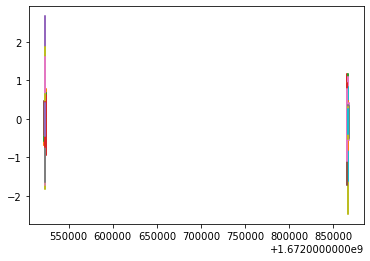

In [1093]:
import matplotlib.pyplot as plt
query= """SELECT * FROM "Session-e3tq3jp6jjh4xjjpvydbqj64e4-dev" WHERE CONTAINS("name", 'ake')"""

sessions_df, sections_df = query_sessions_and_sections(query)
sessions_df = join_sessions_and_sections(sessions_df, sections_df)
sessions_df = normalize_rows(sessions_df)
sessions_df = explode_sessions(sessions_df)

for i in range(sessions_df['isInSection'].max()):
  move = sessions_df.loc[sessions_df['isInSection'] == i+1]
  plt.plot(move['linearAccerationTimestamp'], move['linearAccerationZ'])


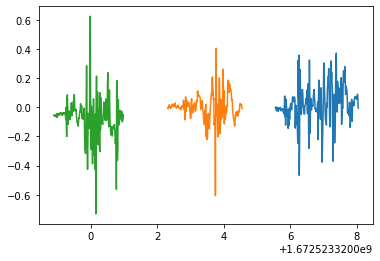

In [1076]:
for i in range(60,63):
  move = sessions_df.loc[sessions_df['isInSection'] == i+1]
  plt.plot(move['linearAccerationTimestamp'], move['linearAccerationZ'])

In [1096]:
import tensorflow as tf
from tensorflow import keras

moves, labels, names = normalize_sessions_df(sessions_df)
print(names)
print(labels)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(500, 7)),
    tf.keras.layers.Dense(3500, activation='relu'),
    tf.keras.layers.Dense(4)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x=moves, y=labels, epochs=10)


{'rotate': 0, 'squat': 1, 'square': 2, 'flip': 3}
[3 3 3 2 2 2 3 3 3 0 0 0 3 3 3 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1 1
 1 1 3 3 3 2 2 2 1 1 1 0 0 0 2 2 2 1 1 1 3 3 3 1 1 1 3 3 3 0 0 0 1 1 1 2 2
 2 0 0 0 0 0 0 1 1 1 3 3 3 1 1 1 0 0 0 1 1 1 0 0 0 3 3 3 0 0 0 3 3 3 2 2 2
 2 2 2 2 2 2 3 3 3]
Epoch 1/10
4/4 [==============================] - 1s 106ms/step - loss: 1.7312 - accuracy: 0.6500
Epoch 2/10
4/4 [==============================] - 0s 109ms/step - loss: 0.2191 - accuracy: 0.9417
Epoch 3/10
4/4 [==============================] - 0s 112ms/step - loss: 0.0682 - accuracy: 0.9917
Epoch 4/10
4/4 [==============================] - 0s 118ms/step - loss: 0.0151 - accuracy: 0.9917
Epoch 5/10
4/4 [==============================] - 1s 115ms/step - loss: 1.7297e-05 - accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 111ms/step - loss: 4.5357e-05 - accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 117ms/step - loss: 9.4834e-05 - accuracy: 1.0000
Epoch 8

{'rotate': 0, 'squat': 1, 'square': 2}


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 11.101782,  37.481102, -41.607918],
       [  9.940914,  35.180885, -38.966576],
       [  9.854171,  39.75834 , -42.68694 ]], dtype=float32)>

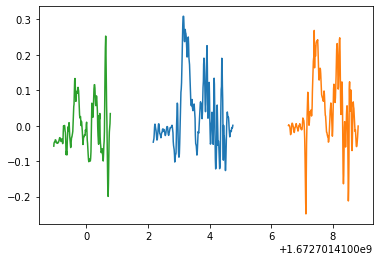

In [1091]:
query= """SELECT * FROM "Session-e3tq3jp6jjh4xjjpvydbqj64e4-dev" WHERE CONTAINS("name", 'test-squat')"""

test_df, sections_df = query_sessions_and_sections(query)
test_df = join_sessions_and_sections(test_df, sections_df)
test_df = normalize_rows(test_df)
test_df = explode_sessions(test_df)


for i in range(test_df['isInSection'].max()):
  move = test_df.loc[test_df['isInSection'] == i+1]
  plt.plot(move['linearAccerationTimestamp'], move['linearAccerationZ'])
  
moves, labels, names = normalize_sessions_df(test_df)
print(names)
model(moves)
  

In [1068]:
import matplotlib.pyplot as plt
query= """SELECT * FROM "Session-e3tq3jp6jjh4xjjpvydbqj64e4-dev" WHERE CONTAINS("name", 'train-noise')"""

noise_df, sections_df = query_sessions_and_sections(query)
# noise_df = join_sessions_and_sections(noise_df, sections_df)
noise_df = normalize_rows(noise_df)
noise_df = explode_sessions(noise_df)

# plt.plot(noise_df['linearAccerationTimestamp'][35:], noise_df['linearAccerationZ'][35:])

noise_df = noise_df.iloc[35:]
noises = []

cols = ['quaternionW',	'quaternionX',	'quaternionY','quaternionZ', 'linearAccerationX', 'linearAccerationZ', 'linearAccerationY'	]

for i in range(0, len(noise_df['linearAccerationZ'])-len(noise_df['linearAccerationZ'])%25, 25):
  noise_section = noise_df[cols].iloc[i:i+25]
  noises.append( noise_section[cols].astype(float) )
    
n = np.array(noises)
 

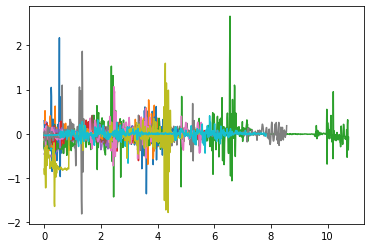

In [994]:

import tensorflow as tf
from tensorflow import keras


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(25, 7)),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(2)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

labels = [0 for i in range(len(n))]

model.fit(x=n, y=labels, epochs=10)
